In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5023, 0.5017, 0.5019])
    std = np.array([0.1245, 0.0934, 0.0581])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.5, contrast=1),
        # transforms.RandomCrop(size=(256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666])
    ])
}

data_dir = 'data/data_m'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

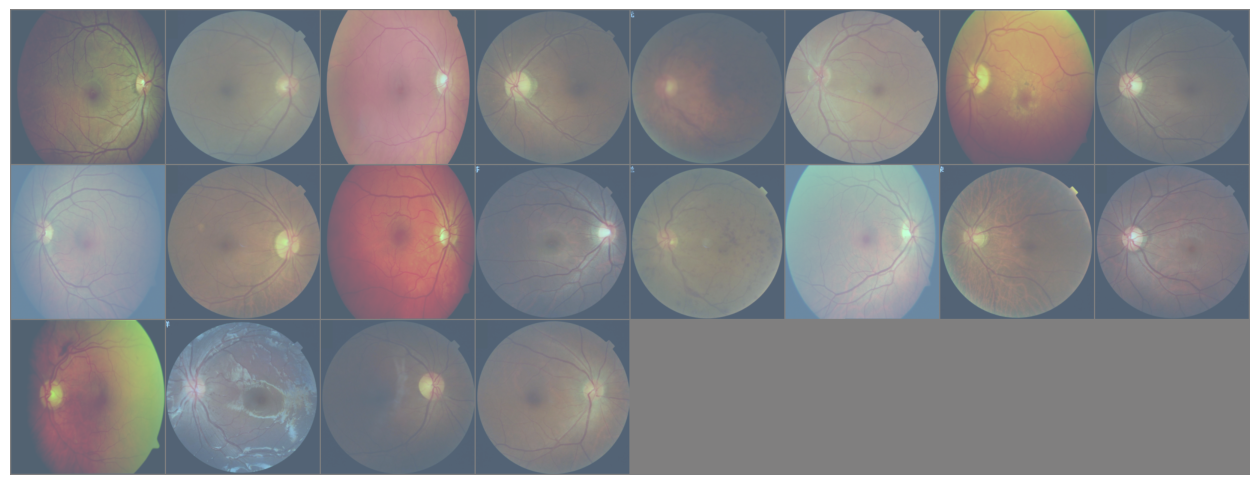

In [4]:
samples, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples)
imgshow(grid_imgs)

In [5]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
num_ftrs = model_ft.classifier.in_features

model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                correct = pred.eq(labels)
                running_corrects += torch.sum(correct.float())
                torch.cuda.empty_cache() 

            epoch_loss = running_loss  / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step()
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc.item())
            else:
                valid_loss_list.append(epoch_loss)
                valid_acc_list.append(epoch_acc.item())                           
            plint = phase if phase == 'train' else 'valid'
            print(f'{plint} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    xepoch = np.arange(num_epochs, dtype=int)+1
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout="constrained")
    
    ax1.plot(xepoch, train_loss_list, label='train')
    ax1.plot(xepoch, valid_loss_list, label='valid')
    ax1.legend(loc="center right")
    ax1.set_ylabel('loss')
    
    ax2.plot(xepoch, train_acc_list, label='train')
    ax2.plot(xepoch, valid_acc_list, label='valid')
    ax2.legend(loc="center right")
    ax2.set_ylabel('accuracy')
    plt.plot()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def test_model(model):    
    was_training = model.training
    model.eval()
    test_acc = 0
    for i, data in enumerate(dataloaders['test'], 0):
        samples, labels = data
        with torch.no_grad():            
            samples, labels = samples.to(device), labels.to(device)
            output = model(samples)
            loss = criterion(output, labels)
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            test_acc += torch.sum(correct.float())
            torch.cuda.empty_cache()
            model.train(mode=was_training)
    print('Testing Accuracy: {:.2f} %'.format(100*test_acc/dataset_sizes['test']))

Epoch [1/15]
train Loss: 0.6402 Acc: 0.6423
valid Loss: 0.5515 Acc: 0.6881
Epoch [2/15]
train Loss: 0.4649 Acc: 0.7911
valid Loss: 0.4204 Acc: 0.7890
Epoch [3/15]
train Loss: 0.3561 Acc: 0.8590
valid Loss: 0.3560 Acc: 0.8440
Epoch [4/15]
train Loss: 0.2695 Acc: 0.9034
valid Loss: 0.3525 Acc: 0.8257
Epoch [5/15]
train Loss: 0.2330 Acc: 0.9034
valid Loss: 0.3499 Acc: 0.8349
Epoch [6/15]
train Loss: 0.2641 Acc: 0.8903
valid Loss: 0.3135 Acc: 0.8440
Epoch [7/15]
train Loss: 0.1800 Acc: 0.9217
valid Loss: 0.2474 Acc: 0.8899
Epoch [8/15]
train Loss: 0.1433 Acc: 0.9530
valid Loss: 0.2392 Acc: 0.8899
Epoch [9/15]
train Loss: 0.1379 Acc: 0.9556
valid Loss: 0.2470 Acc: 0.8899
Epoch [10/15]
train Loss: 0.1388 Acc: 0.9661
valid Loss: 0.2657 Acc: 0.8716
Epoch [11/15]
train Loss: 0.1219 Acc: 0.9687
valid Loss: 0.2840 Acc: 0.8624
Epoch [12/15]
train Loss: 0.1129 Acc: 0.9634
valid Loss: 0.2838 Acc: 0.8716
Epoch [13/15]
train Loss: 0.1262 Acc: 0.9661
valid Loss: 0.2738 Acc: 0.8899
Epoch [14/15]
train L

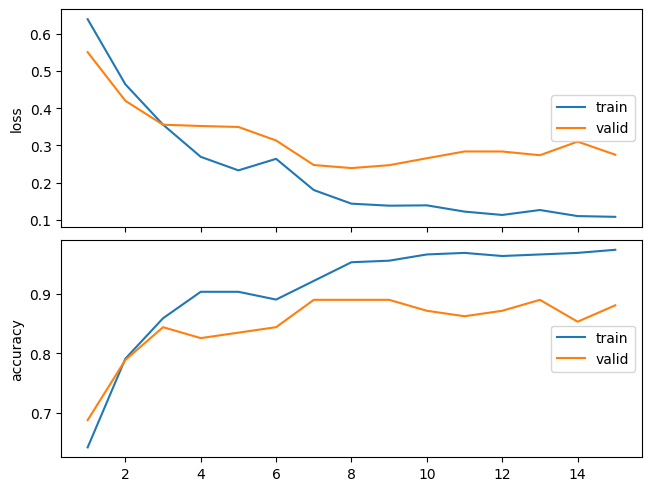

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15 )
test_model(model_ft)

In [9]:
# torch.save(model_ft.state_dict(), 'models/densenet_100epochs_data_raw_norm_randomCropRotation.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Sequential(nn.Linear(num_ftrs, 500),nn.Linear(500,  len(class_names)))
# model_ft.load_state_dict(torch.load('models/dens_4b_24e_17m.pt'))

torch.cuda.empty_cache()